In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence


# LSTM FOR INDIVIDUAL CLAIM DEVELOPMENT FORECASTING
==================================================

Problem: Predict future claim payments given historical payment patterns
Structure: Each claim is ONE row, columns are payment development periods

Example Data Structure:
Claim_ID | Period_1 | Period_2 | Period_3 | Period_4 | ... | Period_N | Ultimate
---------|----------|----------|----------|----------|-----|----------|----------
   001   |   5000   |   2000   |   1500   |    500   | ... |    0     |  15000
   002   |  12000   |   8000   |   3000   |   1000   | ... |    0     |  28000
   003   |   3000   |   1000   |    500   |      ?   | ... |    ?     |    ?

Key Difference from Time Series:
- Each ROW is a claim (not a time window)
- COLUMNS are development periods (inherently sequential)
- Variable length: Claims settle at different speeds
- We want to predict remaining payments AND ultimate loss
"""

# PART 1: Generate realistic claim development data

In [4]:

np.random.seed(42)
torch.manual_seed(42)

# ============================================================================
# PART 1: GENERATE REALISTIC CLAIM DEVELOPMENT DATA
# ============================================================================

def generate_claim_development_data(n_claims=500, max_periods=12):
    """
    Generate synthetic individual claim development patterns
    
    Mimics real insurance claims:
    - Large initial payment (reported loss)
    - Declining incremental payments (development)
    - Some claims settle early, others develop slowly
    - Ultimate loss varies by claim severity
    """
    claims_data = []
    
    for claim_id in range(n_claims):
        # Initial severity (lognormal distribution)
        severity = np.random.lognormal(mean=8.5, sigma=1.2)
        
        # Settlement speed (some claims close fast, others slow)
        speed = np.random.uniform(0.3, 0.9)
        
        # Generate payment pattern
        payments = []
        cumulative = 0
        
        for period in range(max_periods):
            if period == 0:
                # Initial payment (40-70% of ultimate)
                payment = severity * np.random.uniform(0.4, 0.7)
            else:
                # Declining incremental payments
                remaining = severity - cumulative
                if remaining > 100:  # Still open
                    payment = remaining * speed * np.exp(-0.3 * period) * np.random.uniform(0.5, 1.5)
                    payment = min(payment, remaining)  # Can't exceed remaining
                else:
                    payment = remaining  # Close out
            
            payment = max(0, payment)  # No negative payments
            cumulative += payment
            payments.append(payment)
            
            # Claim settles when remaining is negligible
            if (severity - cumulative) < 100:
                break
        
        # Pad with zeros if settled early
        while len(payments) < max_periods:
            payments.append(0)
        
        claims_data.append({
            'claim_id': claim_id,
            'severity': severity,
            'ultimate': cumulative,
            'payments': payments,
            'settlement_period': len([p for p in payments if p > 0])
        })
    
    return claims_data

SAMPLE CLAIM DEVELOPMENT DATA
   claim_id      ultimate  settlement_period     period_1     period_2  \
0         0   8373.971704                 12  5170.039873  1347.163341   
1         1   3499.098960                 12  2045.355466   659.314542   
2         2   2418.738824                 12  1153.782981   390.441951   
3         3   5508.425128                 12  2681.674162  2135.795250   
4         4   3907.893255                 12  2059.410571  1164.413828   
5         5   3327.147761                  6  2095.916137   954.651854   
6         6   6389.570398                 12  3064.969372  1272.593914   
7         7  14222.562146                 12  8823.206485  2877.299925   
8         8   1796.726654                  3  1196.696085   479.732709   
9         9   2600.136689                  4  1227.292151  1181.619441   

     period_3    period_4    period_5    period_6    period_7    period_8  \
0  639.454534  295.762646  446.405986  185.469377  123.367874   33.569824   
1

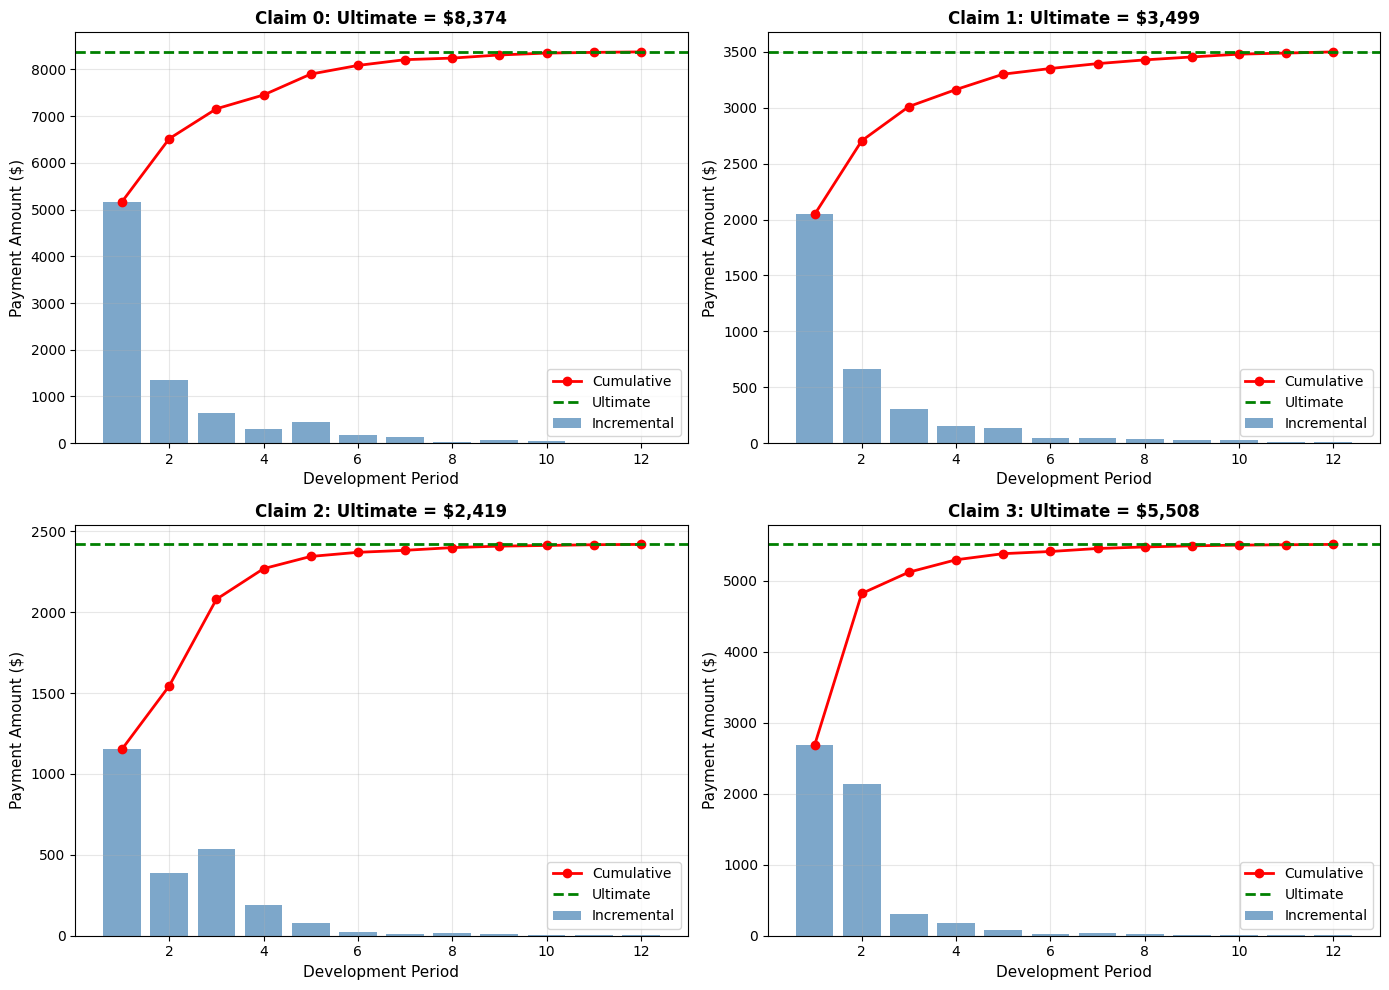

In [5]:
# Generate claims
claims = generate_claim_development_data(n_claims=500, max_periods=12)

# Convert to DataFrame for easier viewing
df_claims = pd.DataFrame([
    {
        'claim_id': c['claim_id'],
        'ultimate': c['ultimate'],
        'settlement_period': c['settlement_period'],
        **{f'period_{i+1}': c['payments'][i] for i in range(len(c['payments']))}
    }
    for c in claims
])

print("="*80)
print("SAMPLE CLAIM DEVELOPMENT DATA")
print("="*80)
print(df_claims.head(10))
print(f"\nTotal Claims: {len(df_claims)}")
print(f"Average Ultimate Loss: ${df_claims['ultimate'].mean():,.2f}")
print(f"Average Settlement Period: {df_claims['settlement_period'].mean():.1f} periods")

# Visualize sample claims
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for idx, ax in enumerate(axes.flat):
    claim = claims[idx]
    periods = range(1, len(claim['payments']) + 1)
    
    # Plot incremental payments
    ax.bar(periods, claim['payments'], alpha=0.7, color='steelblue', label='Incremental')
    
    # Plot cumulative
    cumulative = np.cumsum(claim['payments'])
    ax.plot(periods, cumulative, 'r-', linewidth=2, marker='o', label='Cumulative')
    ax.axhline(y=claim['ultimate'], color='g', linestyle='--', linewidth=2, label='Ultimate')
    
    ax.set_xlabel('Development Period', fontsize=11)
    ax.set_ylabel('Payment Amount ($)', fontsize=11)
    ax.set_title(f"Claim {claim['claim_id']}: Ultimate = ${claim['ultimate']:,.0f}", fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sample_claim_developments.png', dpi=300, bbox_inches='tight')
plt.show()


In [6]:
# ============================================================================
# PART 2: DATA PREPARATION FOR LSTM (THE KEY DIFFERENCE)
# ============================================================================

def prepare_claim_sequences(claims_data, train_split=0.8):
    """
    Prepare data for LSTM claim forecasting
    
    KEY STRUCTURE:
    - Each claim is ONE sequence
    - We observe first N periods, predict remaining periods + ultimate
    - Training: Use various "as-of" dates (partial observations)
    """
    
    sequences = []
    
    for claim in claims_data:
        payments = np.array(claim['payments'])
        ultimate = claim['ultimate']
        
        # Create multiple training samples per claim
        # Observe first k periods, predict remainder
        # This is like evaluating the claim at different development points
        
        settlement = claim['settlement_period']
        
        for observe_until in range(2, min(settlement + 1, len(payments))):
            # Input: payments from period 1 to observe_until
            X = payments[:observe_until].copy()
            
            # Target: remaining payments + ultimate
            remaining_periods = payments[observe_until:].sum()
            
            sequences.append({
                'claim_id': claim['claim_id'],
                'observed_periods': observe_until,
                'input_sequence': X,
                'target_ultimate': ultimate,
                'target_remaining': remaining_periods,
                'paid_to_date': X.sum()
            })
    
    # Split into train/test
    np.random.shuffle(sequences)
    split_idx = int(len(sequences) * train_split)
    train_data = sequences[:split_idx]
    test_data = sequences[split_idx:]
    
    return train_data, test_data

In [7]:
train_data, test_data = prepare_claim_sequences(claims, train_split=0.8)

print("\n" + "="*80)
print("DATA PREPARATION - THE NEW STRUCTURE")
print("="*80)
print(f"Total training sequences: {len(train_data)}")
print(f"Total test sequences: {len(test_data)}")
print("\nSample Training Record:")
sample = train_data[0]
print(f"  Claim ID: {sample['claim_id']}")
print(f"  Observed until period: {sample['observed_periods']}")
print(f"  Input sequence: {sample['input_sequence']}")
print(f"  Paid to date: ${sample['paid_to_date']:,.2f}")
print(f"  Target remaining: ${sample['target_remaining']:,.2f}")
print(f"  Target ultimate: ${sample['target_ultimate']:,.2f}")

print("\n" + "="*80)
print("KEY INSIGHT: VARIABLE LENGTH SEQUENCES")
print("="*80)
print("""
Unlike time series forecasting where all samples have the same seq_length:
- Claim A observed for 3 periods: [5000, 2000, 1500]
- Claim B observed for 5 periods: [12000, 8000, 3000, 1000, 500]
- Claim C observed for 2 periods: [3000, 1000]

All are valid training examples at different stages of development!
We need to handle this with PADDING and MASKING.
""")


DATA PREPARATION - THE NEW STRUCTURE
Total training sequences: 3511
Total test sequences: 878

Sample Training Record:
  Claim ID: 471
  Observed until period: 6
  Input sequence: [18203.89711022  9328.87585009  3376.6531101    491.69599815
   465.36647982   248.12874072]
  Paid to date: $32,114.62
  Target remaining: $338.99
  Target ultimate: $32,453.61

KEY INSIGHT: VARIABLE LENGTH SEQUENCES

Unlike time series forecasting where all samples have the same seq_length:
- Claim A observed for 3 periods: [5000, 2000, 1500]
- Claim B observed for 5 periods: [12000, 8000, 3000, 1000, 500]
- Claim C observed for 2 periods: [3000, 1000]

All are valid training examples at different stages of development!
We need to handle this with PADDING and MASKING.



In [8]:
# ============================================================================
# PART 3: PYTORCH DATASET FOR VARIABLE LENGTH SEQUENCES
# ============================================================================

class ClaimDataset(torch.utils.data.Dataset):
    """Custom Dataset for variable-length claim sequences"""
    
    def __init__(self, data, scaler=None):
        self.data = data
        
        # Fit scaler on training data
        if scaler is None:
            all_payments = np.concatenate([d['input_sequence'] for d in data])
            self.scaler = StandardScaler()
            self.scaler.fit(all_payments.reshape(-1, 1))
        else:
            self.scaler = scaler
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        
        # Normalize input sequence
        X = self.scaler.transform(sample['input_sequence'].reshape(-1, 1))
        X = torch.FloatTensor(X)
        
        # Targets (we'll predict both remaining and ultimate)
        y_remaining = torch.FloatTensor([sample['target_remaining']])
        y_ultimate = torch.FloatTensor([sample['target_ultimate']])
        
        # Also return the length for padding/packing
        seq_length = torch.LongTensor([len(sample['input_sequence'])])

        # return the as of date to track the performance 
        observed_periods = torch.LongTensor([sample['observed_periods']]) 
        
        return X, y_remaining, y_ultimate, seq_length, observed_periods

def collate_fn(batch):
    """Custom collate function to handle variable lengths"""
    X_list, y_remaining_list, y_ultimate_list, lengths, obs_periods= zip(*batch)
    
    # Pad sequences to same length
    X_padded = pad_sequence(X_list, batch_first=True, padding_value=0)
    
    # Stack targets
    y_remaining = torch.stack(y_remaining_list)
    y_ultimate = torch.stack(y_ultimate_list)
    lengths = torch.stack(lengths).squeeze()
    obs_periods = torch.stack(obs_periods).squeeze()
    
    return X_padded, y_remaining, y_ultimate, lengths, obs_periods

# Create datasets
train_dataset = ClaimDataset(train_data)
test_dataset = ClaimDataset(test_data, scaler=train_dataset.scaler)

In [9]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=32, 
    shuffle=False,
    collate_fn=collate_fn
)

In [10]:
# ============================================================================
# PART 4: LSTM MODEL FOR CLAIM RESERVING
# ============================================================================

class ClaimReservingLSTM(nn.Module):
    """
    LSTM for predicting remaining claim payments and ultimate loss
    
    Key features:
    - Handles variable-length sequences
    - Outputs both remaining payments and ultimate loss
    - Uses packed sequences for efficiency
    """
    
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(ClaimReservingLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Prediction heads
        self.fc_remaining = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )
        
        self.fc_ultimate = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )
    
    def forward(self, x, lengths):
        """
        x: (batch, max_seq_len, 1) - padded sequences
        lengths: (batch,) - actual lengths before padding
        """
        # Pack padded sequences for efficient processing
        packed = pack_padded_sequence(
            x, 
            lengths.cpu(), 
            batch_first=True, 
            enforce_sorted=False
        )
        
        # Process through LSTM
        packed_output, (hidden, cell) = self.lstm(packed)
        
        # Use last hidden state (from last layer)
        # Shape: (batch, hidden_size)
        last_hidden = hidden[-1]
        
        # Predict remaining and ultimate
        remaining = self.fc_remaining(last_hidden)
        ultimate = self.fc_ultimate(last_hidden)
        
        return remaining, ultimate

# Initialize model
model = ClaimReservingLSTM(input_size=1, hidden_size=64, num_layers=2, dropout=0.2)
print("\n" + "="*80)
print("MODEL ARCHITECTURE")
print("="*80)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")



MODEL ARCHITECTURE
ClaimReservingLSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc_remaining): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
  (fc_ultimate): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total parameters: 54,658


In [11]:
# ============================================================================
# PART 5: TRAINING WITH DUAL OBJECTIVES
# ============================================================================

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
train_losses = []
test_losses = []

print("\n" + "="*80)
print("TRAINING THE MODEL")
print("="*80)

for epoch in range(num_epochs):
    # Training
    model.train()
    epoch_train_loss = 0
    
    for X_batch, y_remaining_batch, y_ultimate_batch, lengths_batch, obs_periods in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        pred_remaining, pred_ultimate = model(X_batch, lengths_batch)
        
        # Combined loss: predict both remaining and ultimate
        loss_remaining = criterion(pred_remaining, y_remaining_batch)
        loss_ultimate = criterion(pred_ultimate, y_ultimate_batch)
        loss = loss_remaining + loss_ultimate
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
    
    # Evaluation
    model.eval()
    epoch_test_loss = 0
    
    with torch.no_grad():
        for X_batch, y_remaining_batch, y_ultimate_batch, lengths_batch, obs_periods in test_loader:
            pred_remaining, pred_ultimate = model(X_batch, lengths_batch)
            loss_remaining = criterion(pred_remaining, y_remaining_batch)
            loss_ultimate = criterion(pred_ultimate, y_ultimate_batch)
            loss = loss_remaining + loss_ultimate
            epoch_test_loss += loss.item()
    
    train_losses.append(epoch_train_loss / len(train_loader))
    test_losses.append(epoch_test_loss / len(test_loader))
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f}")



TRAINING THE MODEL
Epoch 10/50 | Train Loss: 898675383.7091 | Test Loss: 627702938.5714
Epoch 20/50 | Train Loss: 843921585.3818 | Test Loss: 572319788.6429
Epoch 30/50 | Train Loss: 787654709.6909 | Test Loss: 512271191.8571
Epoch 40/50 | Train Loss: 737260315.5528 | Test Loss: 460899296.5714
Epoch 50/50 | Train Loss: 689016494.8886 | Test Loss: 418842977.6004


In [12]:
# ============================================================================
# PART 6: EVALUATION AND PREDICTIONS
# ============================================================================

model.eval()
all_predictions = []

with torch.no_grad():
    for X_batch, y_remaining_batch, y_ultimate_batch, lengths_batch, obs_periods in test_loader:
        pred_remaining, pred_ultimate = model(X_batch, lengths_batch)
        
        for i in range(len(X_batch)):
            all_predictions.append({
                'observed_periods': obs_periods[i].item(),
                'actual_remaining': y_remaining_batch[i].item(),
                'pred_remaining': pred_remaining[i].item(),
                'actual_ultimate': y_ultimate_batch[i].item(),
                'pred_ultimate': pred_ultimate[i].item()
            })

df_predictions = pd.DataFrame(all_predictions)

In [13]:
# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

results = {}
# Group by observed_periods and compute MAE/R² per group
for obs_period in sorted(df_predictions['observed_periods'].unique()):
    results[obs_period] = {}
    subset = df_predictions[df_predictions['observed_periods'] == obs_period]
    mae_remaining = mean_absolute_error(subset['actual_remaining'], subset['pred_remaining'])
    mae_ult = mean_absolute_error(subset['actual_ultimate'], subset['pred_ultimate'])
    r2_ult = r2_score(subset['actual_ultimate'], subset['pred_ultimate'])
    r2_remaining = r2_score(subset['actual_remaining'], subset['pred_remaining'])
    print(f"Ult. Observed until period {obs_period}: MAE=${mae_ult:,.2f}, R²={r2_ult:.3f}, n={len(subset)}")
    print(f"Remaining Observed until period {obs_period}: MAE=${mae_remaining:,.2f}, R²={r2_remaining:.3f}, n={len(subset)}")
    results[obs_period]['mae_ult'] = mae_ult
    results[obs_period]['r2_ult'] = r2_ult
    results[obs_period]['mae_remaining'] = mae_remaining
    results[obs_period]['r2_remaining'] = r2_remaining

# mae_remaining = mean_absolute_error(df_predictions['actual_remaining'], df_predictions['pred_remaining'])
# mae_ultimate = mean_absolute_error(df_predictions['actual_ultimate'], df_predictions['pred_ultimate'])
# r2_remaining = r2_score(df_predictions['actual_remaining'], df_predictions['pred_remaining'])
# r2_ultimate = r2_score(df_predictions['actual_ultimate'], df_predictions['pred_ultimate'])

# print("\n" + "="*80)
# print("MODEL PERFORMANCE")
# print("="*80)
# print(f"Remaining Payments Prediction:")
# print(f"  MAE: ${mae_remaining:,.2f}")
# print(f"  R²:  {r2_remaining:.4f}")
# print(f"\nUltimate Loss Prediction:")
# print(f"  MAE: ${mae_ultimate:,.2f}")
# print(f"  R²:  {r2_ultimate:.4f}")


Ult. Observed until period 2: MAE=$2,312.75, R²=0.433, n=101
Remaining Observed until period 2: MAE=$1,154.22, R²=0.032, n=101
Ult. Observed until period 3: MAE=$6,517.32, R²=0.074, n=107
Remaining Observed until period 3: MAE=$1,270.90, R²=0.017, n=107
Ult. Observed until period 4: MAE=$3,294.49, R²=0.343, n=93
Remaining Observed until period 4: MAE=$451.75, R²=0.273, n=93
Ult. Observed until period 5: MAE=$4,688.16, R²=0.328, n=94
Remaining Observed until period 5: MAE=$277.89, R²=0.405, n=94
Ult. Observed until period 6: MAE=$7,070.50, R²=0.227, n=87
Remaining Observed until period 6: MAE=$320.82, R²=0.288, n=87
Ult. Observed until period 7: MAE=$1,834.27, R²=0.405, n=79
Remaining Observed until period 7: MAE=$182.55, R²=-0.231, n=79
Ult. Observed until period 8: MAE=$3,696.33, R²=0.323, n=71
Remaining Observed until period 8: MAE=$229.46, R²=-3.346, n=71
Ult. Observed until period 9: MAE=$2,085.92, R²=0.403, n=77
Remaining Observed until period 9: MAE=$319.07, R²=-52.171, n=77
Ult.

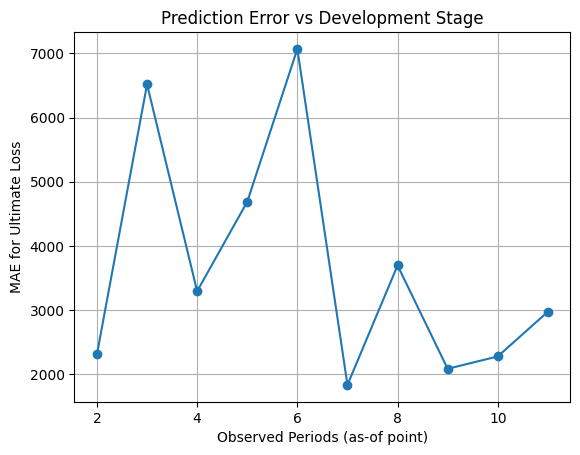

In [14]:
# Plot MAE vs observed_periods
grouped = df_predictions.groupby('observed_periods').apply(
    lambda x: mean_absolute_error(x['actual_ultimate'], x['pred_ultimate'])
)
plt.plot(grouped.index, grouped.values, marker='o')
plt.xlabel('Observed Periods (as-of point)')
plt.ylabel('MAE for Ultimate Loss')
plt.title('Prediction Error vs Development Stage')
plt.grid(True)
plt.show()

In [15]:
observed_periods = np.sort(df_predictions['observed_periods'].unique())
print(observed_periods)


[ 2  3  4  5  6  7  8  9 10 11]


In [18]:
selected_period = 5

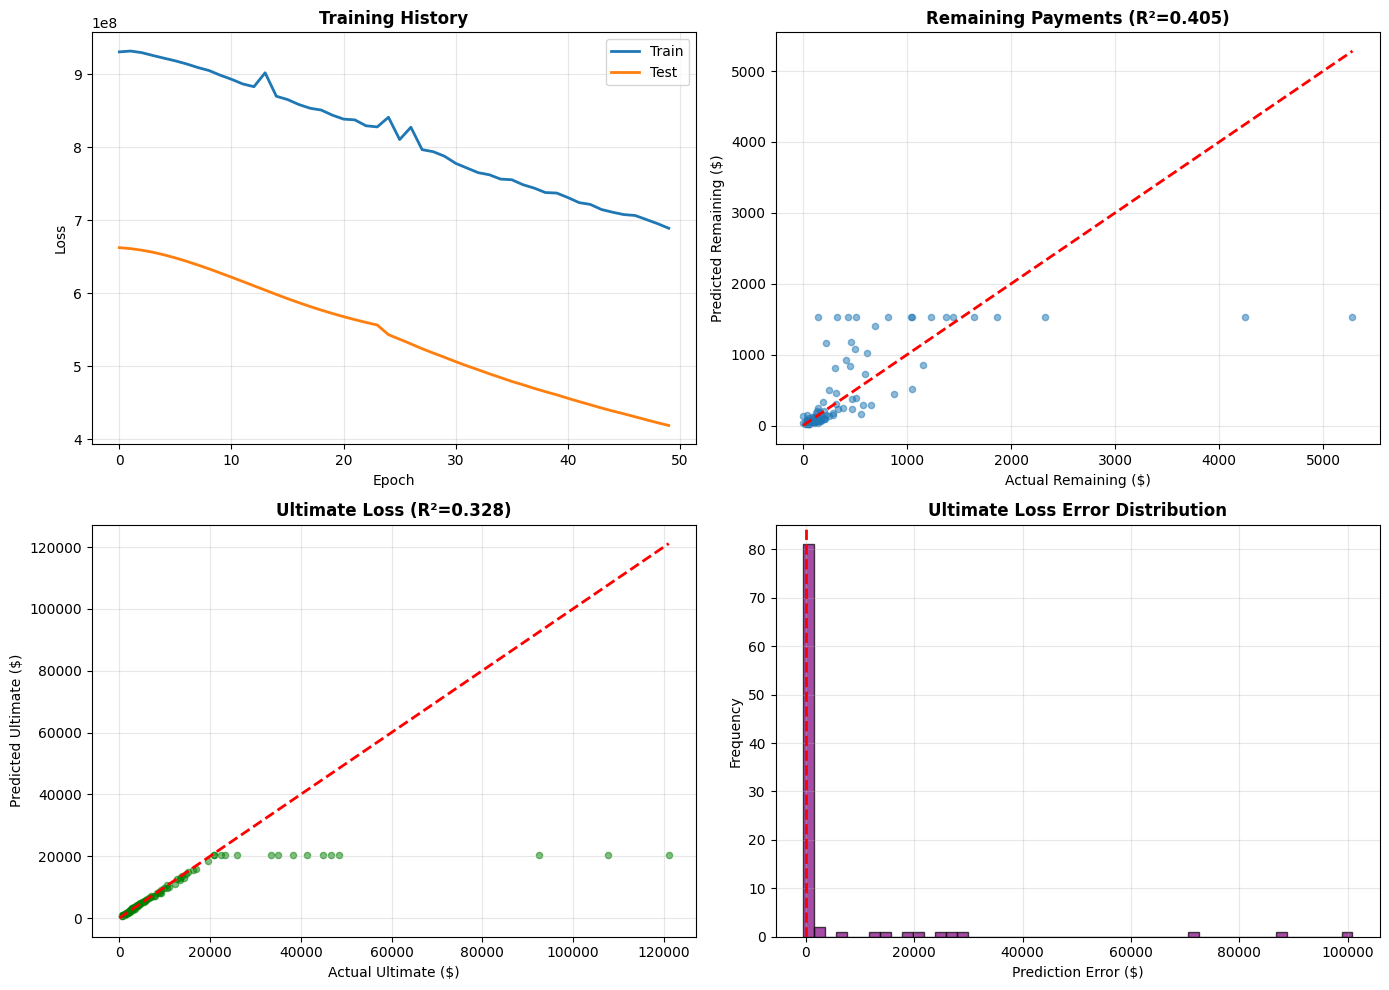

In [21]:
# ============================================================================
# PART 7: VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training loss
axes[0, 0].plot(train_losses, label='Train', linewidth=2)
axes[0, 0].plot(test_losses, label='Test', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training History', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

df_predictions_selected = df_predictions[df_predictions['observed_periods'] == selected_period]

r2_ult = results[selected_period]['r2_ult']

r2_remaining = results[selected_period]['r2_remaining']
max_val = max(df_predictions_selected['actual_remaining'].max(), df_predictions_selected['pred_remaining'].max())

# Plot 2: Remaining payments prediction
axes[0, 1].scatter(df_predictions_selected['actual_remaining'], 
                   df_predictions_selected['pred_remaining'], 
                   alpha=0.5, s=20)
#max_val = max(df_predictions_selected['actual_remaining'].max(), df_predictions_selected['pred_remaining'].max())
axes[0, 1].plot([0, max_val], [0, max_val], 'r--', linewidth=2)
axes[0, 1].set_xlabel('Actual Remaining ($)')
axes[0, 1].set_ylabel('Predicted Remaining ($)')
axes[0, 1].set_title(f'Remaining Payments (R²={r2_remaining:.3f})', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Ultimate loss prediction
axes[1, 0].scatter(df_predictions_selected['actual_ultimate'], 
                   df_predictions_selected['pred_ultimate'], 
                   alpha=0.5, s=20, color='green')
max_val = max(df_predictions_selected['actual_ultimate'].max(), df_predictions_selected['pred_ultimate'].max())
axes[1, 0].plot([0, max_val], [0, max_val], 'r--', linewidth=2)
axes[1, 0].set_xlabel('Actual Ultimate ($)')
axes[1, 0].set_ylabel('Predicted Ultimate ($)')

axes[1, 0].set_title(f'Ultimate Loss (R²={r2_ult:.3f})', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Error distribution
errors_ultimate = df_predictions_selected['actual_ultimate'] - df_predictions_selected['pred_ultimate']
axes[1, 1].hist(errors_ultimate, bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Prediction Error ($)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Ultimate Loss Error Distribution', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('claim_reserving_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
# ============================================================================
# PART 8: PRACTICAL APPLICATION - RESERVE ESTIMATION
# ============================================================================

print("\n" + "="*80)
print("PRACTICAL APPLICATION: PORTFOLIO RESERVE ESTIMATION")
print("="*80)

# Simulate current portfolio (claims at various development stages)
current_claims = claims[:50]  # Use first 50 claims as "current" portfolio

total_paid = 0
total_reserved_actual = 0
total_reserved_predicted = 0

model.eval()
with torch.no_grad():
    for claim in current_claims:
        # Observe claim up to a random development point
        # observe_until = np.random.randint(2, min(claim['settlement_period'], 8))
        
        # based on the information we got from the training and test, we are forcing the model to evaluate at a certain given point in time
        observe_until = 5

        observed_payments = claim['payments'][:observe_until]
        paid_to_date = sum(observed_payments)
        actual_remaining = claim['ultimate'] - paid_to_date
        
        # Prepare input
        X = train_dataset.scaler.transform(np.array(observed_payments).reshape(-1, 1))
        X = torch.FloatTensor(X).unsqueeze(0)  # Add batch dimension
        length = torch.LongTensor([observe_until])
        
        # Predict
        pred_remaining, pred_ultimate = model(X, length)
        
        total_paid += paid_to_date
        total_reserved_actual += actual_remaining
        total_reserved_predicted += pred_remaining.item()

print(f"\nPortfolio Summary (50 claims):")
print(f"  Total Paid to Date:        ${total_paid:,.2f}")
print(f"  Actual Reserve Needed:     ${total_reserved_actual:,.2f}")
print(f"  LSTM Predicted Reserve:    ${total_reserved_predicted:,.2f}")
print(f"  Prediction Error:          ${abs(total_reserved_actual - total_reserved_predicted):,.2f}")
print(f"  Error %:                   {100 * abs(total_reserved_actual - total_reserved_predicted) / total_reserved_actual:.2f}%")

print("\n" + "="*80)
print("KEY ADVANTAGES FOR ACTUARIES")
print("="*80)
print("""
1. CLAIM-LEVEL PREDICTIONS: Unlike triangle methods, this predicts individual claims
2. VARIABLE DEVELOPMENT: Handles claims that settle at different speeds
3. DYNAMIC UPDATES: Re-predict reserves as new payments are observed
4. FEATURE RICH: Can add claim characteristics (injury type, jurisdiction, adjuster)
5. NO TRIANGLE NEEDED: Works with raw transaction data
6. PARTIAL INFORMATION: Predicts from any development stage

NEXT STEPS FOR PRODUCTION:
- Add claim features (injury severity, jurisdiction, policy type)
- Use attention mechanism for interpretability
- Implement uncertainty quantification (prediction intervals)
- Compare to chain-ladder and Bornhuetter-Ferguson methods
- Handle reopened claims and late reported claims
""")


PRACTICAL APPLICATION: PORTFOLIO RESERVE ESTIMATION

Portfolio Summary (50 claims):
  Total Paid to Date:        $537,806.11
  Actual Reserve Needed:     $24,879.10
  LSTM Predicted Reserve:    $19,886.62
  Prediction Error:          $4,992.48
  Error %:                   20.07%

KEY ADVANTAGES FOR ACTUARIES

1. CLAIM-LEVEL PREDICTIONS: Unlike triangle methods, this predicts individual claims
2. VARIABLE DEVELOPMENT: Handles claims that settle at different speeds
3. DYNAMIC UPDATES: Re-predict reserves as new payments are observed
4. FEATURE RICH: Can add claim characteristics (injury type, jurisdiction, adjuster)
5. NO TRIANGLE NEEDED: Works with raw transaction data
6. PARTIAL INFORMATION: Predicts from any development stage

NEXT STEPS FOR PRODUCTION:
- Add claim features (injury severity, jurisdiction, policy type)
- Use attention mechanism for interpretability
- Implement uncertainty quantification (prediction intervals)
- Compare to chain-ladder and Bornhuetter-Ferguson methods
